# Projeto usando equivalentes discretos

Objetivo: digitalizar (isto é, obter a equação de diferenças) de um controlador **contínuo** que já está projetado. 

O resultado é obtido em duas partes:  

    1 - Obtem-se uma função de transferência discreta a partir de uma contínua
    2 - Converte-se a função discreta em uma equação de diferenças

A equação de diferenças pode ser implementada no microcontrolador sem grandes dificuldades. 

A seguir vemos 2 métodos para fazer a parte (1).

## Método de Tustin

Idéia central: tratar a aproximação discreta como integração numérica

<p align="center">
    <img src="Fig8.7.svg">
</p>

$$
\begin{align}
    u[k] = u[k-1] + \frac{T}{2}\left(e[k]+e[k-1]\right)
\end{align}
$$

Transformando:  
$$
\begin{align}
    \frac{U(z)}{E(z)} = \frac{T}{2}\,\frac{1+z^{-1}}{1-z^{-1}}
\end{align}
$$

$$
\begin{align}
    s \longmapsto \frac{2}{T}\,\frac{1-z^{-1}}{1+z^{-1}} = \frac{2}{T}\,\frac{z-1}{z+1}
\end{align}
$$

**Outra forma de deduzir**

Série de Taylor: $e^{x} \approx 1 + x$

Então
$$
\begin{align}
    z = e^{sT} = \frac{e^{sT/2}}{e^{-sT/2}} \approx \frac{1+sT/2}{1-sT/2} 
\end{align}
$$

Resolvendo $s$ em função de $z$ resulta na mesma equação.


**Exemplo 8.1:**

$$
\begin{align}
    D(s) = 10\,\frac{s/2+1}{s/10+1}
\end{align}
$$

$\omega_s = 25\cdot \omega_{BW} =250$ rad/s. 

$f_s \approx 40$ Hz. $T =1/40 = 0.025$ seg. 

In [1]:
#@ Conversão usando função c2d
import control as ct

T = 0.025
Ds = 10*ct.tf([1/2,1],[1/10,1])
print('Contínuo: ',Ds)
Dz = ct.c2d(Ds,T,method='bilinear')
print('Discreto: ', Dz)

Contínuo:  
5 s + 10
---------
0.1 s + 1

Discreto:  
45.56 z - 43.33
---------------
  z - 0.7778

dt = 0.025



In [2]:
# Pode-se fazer usando SymPy também
import sympy as sp
from IPython.display import display 

T = 0.025
s,z = sp.symbols(['s', 'z'])
Ds = 10*(s/2+1)/(s/10+1)
Dz =  Ds.subs(s,(2/T)*(z-1)/(z+1))
print('Usando simbólico')
Dz = Dz.simplify()
Dz

Usando simbólico


10*(410.0*z - 390.0)/(90.0*z - 70.0)

Sempre é bom fazer uma simulação e ver se os resultados são coerentes. Tente melhorar os resultados com o período de amostragem. 

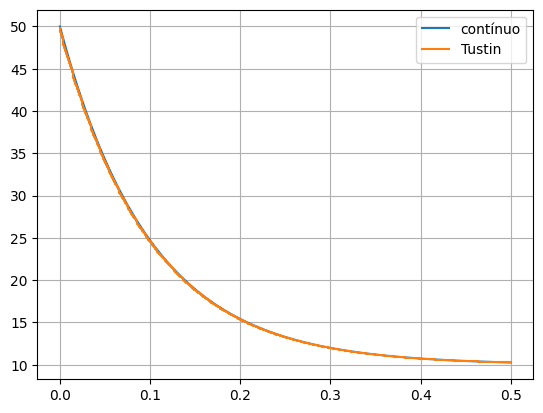

In [3]:
T = 0.001
Ds = 10*ct.tf([1/2,1],[1/10,1])
Dz = ct.c2d(Ds,T,method='bilinear')
td,yd = ct.step_response(Dz,0.5)
t,y = ct.step_response(Ds,0.5)
from matplotlib import pyplot as plt

plt.plot(t,y,label='contínuo')
plt.step(td,yd,label='Tustin')
plt.grid()
plt.legend()
plt.show()

In [4]:
#u_1
#e_1

#while True:
#    y = le_sensor();
#    r = 1;
#    e = r-y;
#    u = 0.7778*u_1+45.56*e-43.33*e_1;
#    U = map(u,0,255)
#    analog_write(U)
#    u_1 = u
#    e_1 = e
#    k = k+1


## Mapeamento de pólos e zeros

- Calcule um pólo/zero discreto para cada pólo/zero contínuo usando $z=e^{sT}$. 
- Iguale o número de zeros ao de pólos adicionando termos $(z+1)$ ao numerador
- Multiplique a função de transferência por um ganho de modo que o ganho DC discreto seja igual ao contínuo. 

**Exemplo 8.2**: 

O controlador encontrado é $D(s) = 0.81\,\displaystyle\frac{s+0.2}{s+2}$. O período de amostragem estabelecido é 1 segundo. O controlador possui um pólo em $s=-2$ e um zero $s=-0.2$.

Como o controlador tem o mesmo número de pólos e zeros, então o controlador digital deverá ser da forma:
$$
\begin{align}
    \hat{D}(z) &= K \frac{z-a}{z-b}
\end{align}
$$

Cálculo do pólo: $b = \exp(-2\cdot 1)$ (resultado será visto em Python)  
Cálculo do zero: $a = \exp(-0.2\cdot 1)$  

O ganho digital $K$ é calculado igualando os ganhos DC da FT contínua e discreta, $D(0)=\hat{D}(1)$.


In [5]:
## Exemplo 8.2 - resolução simbólica
import numpy as np
from IPython.display import display, Math

dmath = lambda s: display(Math(s))

T = 1
a = np.exp(-0.2*T).round(4)
b = np.exp(-2*T).round(4)

# Resolvido com simbólico
Ds = 0.81*(s+0.2)/(s+2)
K = sp.symbols('K')
Dz = K*(z-a)/(z-b)
equacao = sp.Eq(Ds.subs(s,0), Dz.subs(z,1))
print('Substituindo s=0 e z=1 nas funções resulta na igualdade: \n')
dmath(sp.latex(equacao))


Substituindo s=0 e z=1 nas funções resulta na igualdade: 



<IPython.core.display.Math object>

In [6]:
print('Resolvendo para K')
sol = sp.solve(equacao)
display(Math('K = ' + sp.latex(sol[0])))

Resolvendo para K


<IPython.core.display.Math object>

In [7]:
print('Então: ')
Dz = Dz.subs(K,sol[0].round(4))
display(Math('D(z) = ' + sp.latex(Dz)))
display(Math('D(z) = ' + r'\frac{' + sp.latex(sp.numer(Dz)) + r'}{' + sp.latex(sp.denom(Dz)) + r'}'))

Então: 


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Fazer com o módulo "control" é um pouco mais direto. Acompanhe:

In [8]:
Ds = 0.81*ct.tf([1,0.2],[1,2])         # Define a FT continua
T = 0.020                               # Período de amostragem
a = np.exp(T*Ds.zeros())               # Calcula todos os zeros de D(s)
b = np.exp(T*Ds.poles())               # Calcula todos os polos de D(s)
num = np.poly(a)                       # Calcula o polinomio numerador
den = np.poly(b)                       # Calcula o polinômio denominador
Dz = ct.tf(num,den,T)                  # Define a FT discreta sem ganho
Dz = Dz*Ds.dcgain()/Dz.dcgain()        # Redefine com o ganho correto
Dz

TransferFunction(array([ 0.081     , -0.08067665]), array([ 0.10180958, -0.09781757]), 0.02)

Vamos fazer uma simulação para conferir:

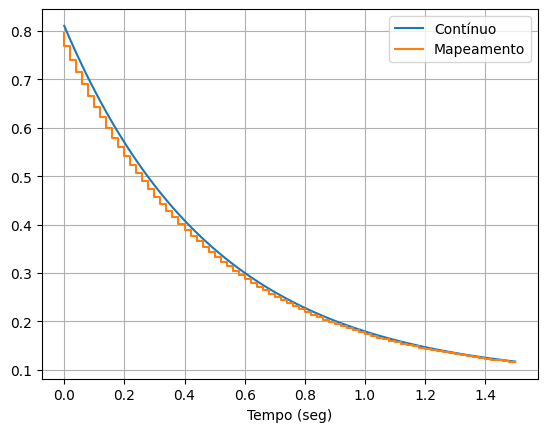

In [9]:
t,y = ct.step_response(Ds,1.5)
k,yd = ct.step_response(Dz,1.5)
plt.plot(t,y,label='Contínuo')
plt.step(k,yd,label='Mapeamento')
plt.grid()
plt.xlabel('Tempo (seg)')
plt.legend()
plt.show()


### **Exemplo um pouco mais complexo:**

Ache o equivalente por mapeamento da função:
$$
\begin{align}
    G(s) &= \frac{s^2-1}{s(s^2+16)}
\end{align}
$$

Utilize $T=0.01$. 

In [17]:
from numpy import exp, round
T = 0.05
pz_s = [-1,1,0,4j,-4j]
pz_z = [exp(s*T) for s in pz_s]
pz_z

[0.951229424500714,
 1.0512710963760241,
 1.0,
 (0.9800665778412416+0.19866933079506122j),
 (0.9800665778412416-0.19866933079506122j)]

In [32]:
K1, K2 = sp.symbols('K_1 K_2')
G1 = K1*(z-pz_z[0])*(z-pz_z[1])/ \
    ((z-pz_z[2])*(z-pz_z[3])*(z-pz_z[4]))
G2 = K2*(z-pz_z[0])*(z-pz_z[1])*(z+1)/ \
    ((z-pz_z[2])*(z-pz_z[3])*(z-pz_z[4]))
DC1 = sp.simplify(G1*(z-1)).subs(z,1)
DC2 = sp.simplify(G2*(z-1)).subs(z,1)
DC = -1/16
k1 = sp.solve(sp.Eq(DC1,DC))[0]
k2 = sp.solve(sp.Eq(DC2,DC))[0]
G2.subs(K2,k2)

0.498231747038069*(z - 1.05127109637602)*(z - 0.951229424500714)*(z + 1)/((z - 1.0)*(z - 0.980066577841242 - 0.198669330795061*I)*(z - 0.980066577841242 + 0.198669330795061*I))

In [40]:
s,t = sp.symbols('s t')
H = sp.apart(10/(s*(3*s+1)))
H

-30/(3*s + 1) + 10/s

In [42]:
sp.inverse_laplace_transform(H,s,t).expand()

10*Heaviside(t) - 10*exp(-t/3)*Heaviside(t)

In [50]:
ct.c2d(ct.tf(10,[3,1]),0.1,method='zoh')

TransferFunction(array([0.327839]), array([ 1.       , -0.9672161]), 0.1)

## Converter para equação de diferenças.

Para converter a função do controlador para uma equação de diferenças, introduzimos os sinais de entrada e saída do controlador, distribuimos os coeficientes da equação depois aplicamos a transformada inversa. 

Normalmente a equação de diferenças é escrita em termos de **atrasos** (valores passados), então pode ser conveniente converter a função discreta para potências negativas antes de fazer a transformação.

## Voltando ao exemplo 8.2:

Como o sistema é de ordem (grau do denominador) 1, multiplicamos numerador e denominador por $z^{-1}$.

$$
\begin{align}
    D(z) &= \frac{0.3863𝑧−0.3162}{𝑧−0.1353}\,\cdot \frac{z^{-1}}{z^{-1}}\\
    &= \frac{0.3863−0.3162z^{-1}}{1−0.1353z^{-1}}
\end{align}
$$

Introduzimos os sinais de entrada $E(z)$ (erro) e saída $U(z)$ (ação de controle) na equação e distribuimos.

$$
\begin{align}
    \frac{U(z)}{E(z)}&= \frac{0.3863−0.3162z^{-1}}{1−0.1353z^{-1}}\\
    (1−0.1353z^{-1})\,U(z) &= (0.3863−0.3162z^{-1}) E(z)\\
    U(z) &= 0.1353z^{-1}U(z) + 0.3863E(z)−0.3162z^{-1}E(z)
\end{align}
$$

Aplicando a transformada inversa e a propriedade do atraso temos a equação que implementa o controlador:

$$
\begin{align}
    u[k] &= 0.1353u[k-1] + 0.3863e[k]−0.3162e[k-1]
\end{align}
$$


## Limitações